In [1]:
import datalib as dl
import params as p
import talib
import numpy as np
import nn
import backtest as bt
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials

SyntaxError: name 'roc_period' is assigned to before global declaration (params.py, line 326)

In [2]:
p.load_config('ETHUSDROC')


**************** Loaded Config for ETHUSDROC ****************


In [5]:
eth = dl.load_data('ETH', 'USD')
btc = dl.load_data('BTC', 'USD')

Loaded ETHUSD prices from KRAKEN via cc Rows:1844 Date:2020-08-23 00:00:00
Last complete day close: 395.52
Loaded BTCUSD prices from KRAKEN via cc Rows:2514 Date:2020-08-23 00:00:00
Last complete day close: 11672.7


In [6]:
prices = {'ETH': eth, 'BTC': btc}

In [7]:
def test_model(m):
    columns = ['date', 'open', 'close', 'y_pred_val', 'DR']
    m['ETH'] = m['ETH'][columns]
    m['BTC'] = m['BTC'][columns]
    m['BTC']['y_pred_val'] = 0

    basket = pd.merge(m['ETH'], m['BTC'], on='date', how='left', suffixes=('_ETH','_BTC')).sort_values('date')
    basket['buy_signals'] = basket['y_pred_val_ETH'] + basket['y_pred_val_BTC']
    basket['share_ETH'] = np.where(basket['y_pred_val_ETH'] == 1, 1/basket['buy_signals'], 0)
    basket['share_BTC'] = np.where(basket['y_pred_val_BTC'] == 1, 1/basket['buy_signals'], 0)

    basket['DR'] = 0.5*basket['DR_ETH'] + 0.5*basket['DR_BTC']
    basket['CMR'] = np.cumprod(basket.DR)

    basket['SR'] = np.where(basket['buy_signals'] > 0, basket['share_ETH']*basket['DR_ETH'] + basket['share_BTC']*basket['DR_BTC'], 1)
    basket['CSR'] = np.cumprod(basket.SR)
    
#     bt.plot_chart(basket, 'basket', 'date')
    return basket.CSR.iloc[-1]

In [8]:
def run_model(prices=prices, rsi_period=14, roc_period=20, rsi_min=0, roc_min=0, sma1_period=10, sma2_period=10):
    markets = {}
    for coin in prices:
        ds = prices[coin]
        ds['DR'] = ds['close'] / ds['close'].shift(1)
        ds['RSI'] = talib.RSI(ds['close'].values, timeperiod = rsi_period)
        ds['ROC'] = talib.ROC(ds['close'].values, timeperiod = roc_period)
        ds['MA1'] = talib.SMA(ds['close'], timeperiod = sma1_period)
        ds['MA2'] = talib.SMA(ds['close'], timeperiod = sma2_period)
#         ds = ds[ds.date >= '2015-02-01']
        ds = ds.dropna()
#         y_pred_val = np.where((ds.RSI > rsi_min) & (ds.ROC > roc_min) & (ds.MA1 >= ds.MA2), 1, 0)
        y_pred_val = np.where(ds.ROC > roc_min, 1, 0)
        y_pred_val = y_pred_val[:-2]
        td = nn.gen_signal(ds, y_pred_val)
        markets[coin] = td
    
    csr = test_model(markets)
    return csr

In [14]:
def f(space):
    return -run_model(
#         rsi_period=space['rsi_period'], 
        roc_period=space['roc_period'], 
#         rsi_min=space['rsi_min'], 
        roc_min=space['roc_min'] 
#         sma1_period=space['sma1_period'], 
#         sma2_period=space['sma2_period']
    )
	
space = {
#     'rsi_period': hp.quniform('rsi_period', 2, 100, 1),
    'roc_period': hp.quniform('roc_period', 2, 100, 1),
#     'rsi_min': hp.quniform('rsi_min', 0, 100, 1),
    'roc_min': hp.quniform('roc_min', 0, 100, 1)
#     'sma1_period': hp.quniform('sma1_period', 2, 200, 1),
#     'sma2_period': hp.quniform('sma2_period', 2, 200, 1)
}

trials = Trials()

best = fmin(
    fn=f,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

print(best)

  1%|          | 7/1000 [00:00<00:34, 29.01trial/s, best loss: -251.84033827995867]

/Users/igor/.local/share/virtualenvs/q-trader-FIeA7-di/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """



100%|██████████| 1000/1000 [01:09<00:00, 14.31trial/s, best loss: -9357.893749289917]
{'roc_min': 0.0, 'roc_period': 18.0}


In [93]:
def get_best_trials(trials):
    loss = 0
    for t in trials:
        if t['result']['loss'] < loss:
            loss = t['result']['loss']
            print(loss)
            print(t['misc']['vals'])

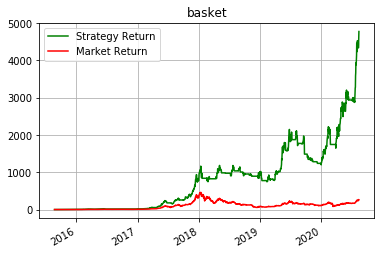

4777.503355005707

In [14]:
# Best ETH + BTC Model
run_model(roc_min = 3, roc_period = 16)

/Users/igor/.local/share/virtualenvs/q-trader-FIeA7-di/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


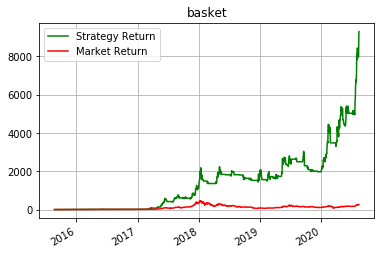

9295.142333722813

In [9]:
# Best ETH only model
run_model(roc_min = 2, roc_period = 16)

Results
+ ETH only model model performs better than ETH + BTC
+ Best parameters: roc_min = 2, roc_period = 16
+ SMA and RSI are not required

Position Sizing for Combo model:
+ Strategy Return: 68801.08
+ Market Return: 475.96
+ Sortino Ratio: 9.21

No position sizing for Combo model:
+ Strategy Return: 196456.69
+ Market Return: 475.95
+ Sortino Ratio: 8.24

Adding to Ensemble does not improve profit


Backtest

Using TensorFlow backend.



**************** Loaded Config for ETHUSDROC ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39


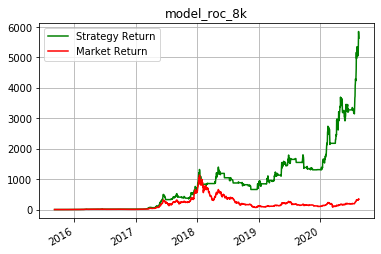

Strategy Return: 5633.66
Market Return: 342.19
Sortino Ratio: 4.18
Bars in Trade: 11
Buy Pct: 0.51
Accuracy: 0.55
Win Ratio: 0.53
Avg Win: 0.29
Avg Loss: 0.03
Risk to Reward: 10.62
Expectancy: 4.48
Sharpe Ratio: 2.34
Average Daily Return: 0.012
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Buy Open: 432.39 P/L: 75.39%


In [1]:
import nn

In [ ]:
Ensemble

Using TensorFlow backend.



**************** Loaded Config for ETHUSDENS ****************

**************** Loaded Config for ETHUSDNN1 ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39
Loaded ETHBTC prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 0.03649


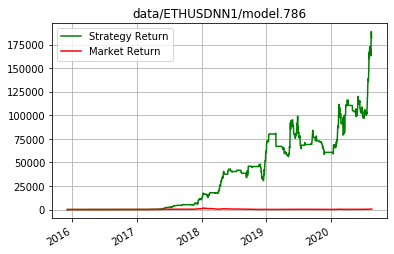

Strategy Return: 182161.07
Market Return: 491.57
Sortino Ratio: 7.25
Bars in Trade: 4
Buy Pct: 0.44
Accuracy: 0.56
Win Ratio: 0.59
Avg Win: 0.09
Avg Loss: 0.02
Risk to Reward: 3.90
Expectancy: 3.55
Sharpe Ratio: 3.33
Average Daily Return: 0.010
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Buy Open: 432.39 P/L: 84.44%

**************** Loaded Config for ETHUSDNN1S ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39
Loaded ETHBTC prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 0.03649


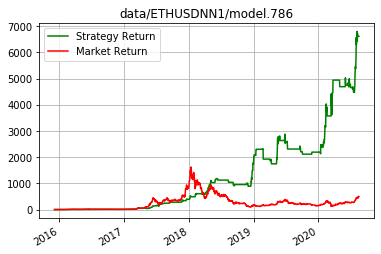

Strategy Return: 6610.04
Market Return: 491.57
Sortino Ratio: 5.96
Bars in Trade: 4
Buy Pct: 0.24
Accuracy: 0.56
Win Ratio: 0.58
Avg Win: 0.06
Avg Loss: 0.01
Risk to Reward: 4.44
Expectancy: 2.53
Sharpe Ratio: 2.84
Average Daily Return: 0.007
SL: 0.02 TP: 0.00
ETH/USD: Same Signal: Cash Open: 432.39

**************** Loaded Config for ETHUSDNN2 ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39


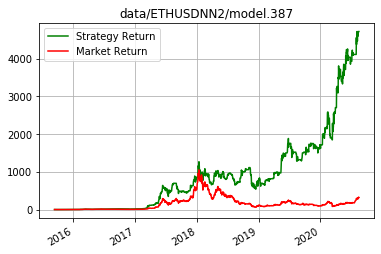

Strategy Return: 4723.02
Market Return: 318.34
Sortino Ratio: 3.84
Bars in Trade: 4
Buy Pct: 0.55
Accuracy: 0.56
Win Ratio: 0.61
Avg Win: 0.06
Avg Loss: 0.03
Risk to Reward: 2.23
Expectancy: 2.50
Sharpe Ratio: 2.16
Average Daily Return: 0.007
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Sell Open: 432.39 P/L: 0.0%

**************** Loaded Config for ETHUSDROC ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39


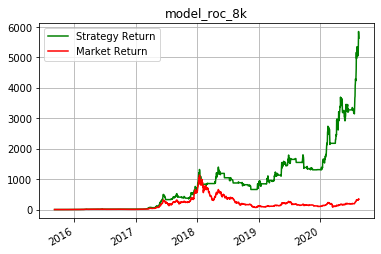

Strategy Return: 5633.66
Market Return: 342.19
Sortino Ratio: 4.18
Bars in Trade: 11
Buy Pct: 0.51
Accuracy: 0.55
Win Ratio: 0.53
Avg Win: 0.29
Avg Loss: 0.03
Risk to Reward: 10.62
Expectancy: 4.48
Sharpe Ratio: 2.34
Average Daily Return: 0.012
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Buy Open: 432.39 P/L: 75.39%

**************** Loaded Config for ETHUSDENS ****************


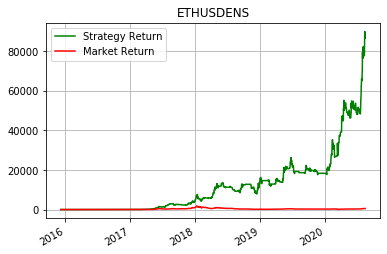

Strategy Return: 86599.60
Market Return: 535.13
Sortino Ratio: 5.66
Bars in Trade: 5
Buy Pct: 0.55
Accuracy: 0.57
Win Ratio: 0.59
Avg Win: 0.12
Avg Loss: 0.03
Risk to Reward: 4.63
Expectancy: 4.78
Sharpe Ratio: 2.95
Average Daily Return: 0.013
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Buy Open: 432.39 P/L: 75.59%


In [1]:
import nn

Original Ensemble (Risk+Safe+Moon)

Using TensorFlow backend.



**************** Loaded Config for ETHUSDENS ****************

**************** Loaded Config for ETHUSDNN1 ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39
Loaded ETHBTC prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 0.03649


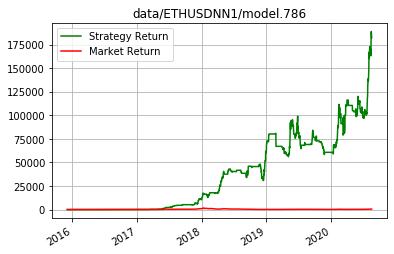

Strategy Return: 182338.12
Market Return: 492.05
Sortino Ratio: 7.25
Bars in Trade: 4
Buy Pct: 0.44
Accuracy: 0.56
Win Ratio: 0.59
Avg Win: 0.09
Avg Loss: 0.02
Risk to Reward: 3.90
Expectancy: 3.55
Sharpe Ratio: 3.33
Average Daily Return: 0.010
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Buy Open: 432.39 P/L: 84.62%

**************** Loaded Config for ETHUSDNN1S ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39
Loaded ETHBTC prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 0.03649


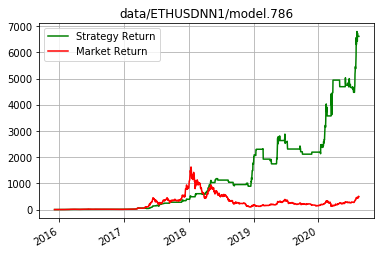

Strategy Return: 6610.04
Market Return: 490.34
Sortino Ratio: 5.96
Bars in Trade: 4
Buy Pct: 0.24
Accuracy: 0.56
Win Ratio: 0.58
Avg Win: 0.06
Avg Loss: 0.01
Risk to Reward: 4.44
Expectancy: 2.53
Sharpe Ratio: 2.84
Average Daily Return: 0.007
SL: 0.02 TP: 0.00
ETH/USD: Same Signal: Cash Open: 432.39

**************** Loaded Config for ETHUSDNN2 ****************
Loaded ETHUSD prices from KRAKEN via cc Rows:1837 Date:2020-08-16 00:00:00
Last complete day close: 432.39


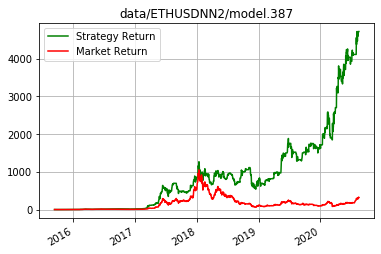

Strategy Return: 4723.02
Market Return: 317.54
Sortino Ratio: 3.84
Bars in Trade: 4
Buy Pct: 0.55
Accuracy: 0.56
Win Ratio: 0.61
Avg Win: 0.06
Avg Loss: 0.03
Risk to Reward: 2.23
Expectancy: 2.50
Sharpe Ratio: 2.16
Average Daily Return: 0.007
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Sell Open: 432.39 P/L: 0.0%

**************** Loaded Config for ETHUSDENS ****************


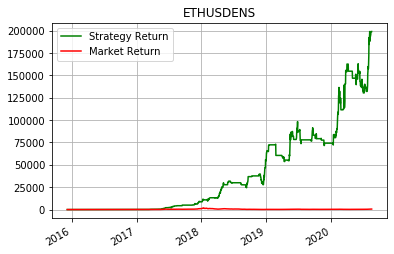

Strategy Return: 199108.56
Market Return: 535.65
Sortino Ratio: 8.24
Bars in Trade: 4
Buy Pct: 0.35
Accuracy: 0.57
Win Ratio: 0.61
Avg Win: 0.08
Avg Loss: 0.02
Risk to Reward: 3.90
Expectancy: 3.48
Sharpe Ratio: 3.51
Average Daily Return: 0.010
SL: 0.00 TP: 0.00
ETH/USD: Same Signal: Sell Open: 432.39 P/L: 0.0%


In [1]:
import nn

Loaded ETHUSD prices from KRAKEN via cc Rows:1844 Date:2020-08-23 00:00:00
Last complete day close: 395.52


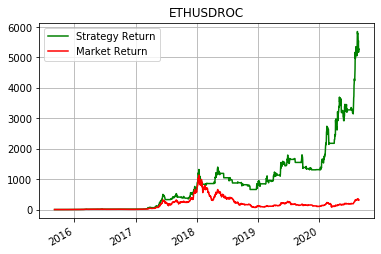

Strategy Return: 5276.09
Market Return: 314.83
Sortino Ratio: 4.14
Bars in Trade: 11
Buy Pct: 0.51
Accuracy: 0.55
Win Ratio: 0.53
Avg Win: 0.29
Avg Loss: 0.03
Risk to Reward: 10.44
Expectancy: 4.44
Sharpe Ratio: 2.32
Average Daily Return: 0.012
SL: 0.00 TP: 0.00


In [10]:
td = nn.runNN3()

In [39]:
def run_model(ticker='BTC', period=16, threshold=2, delay=2):
    global ds

    ds = dl.load_data(ticker, p.currency)
    ds['DR'] = ds['close'] / ds['close'].shift(1)
    ds['ROC'] = talib.ROC(ds['close'].values, timeperiod=period)

    ds['y_pred_val'] = np.where(ds.ROC > threshold, 1, 0)
    # Delay signal for 1 day
    ds['y_pred_val'] = ds['y_pred_val'].shift(delay)
    td = nn.gen_signal(ds, ds['y_pred_val'])

    # Backtesting
    td = bt.run_backtest(td, p.conf)

    return td.CSR.iloc[-1]

In [44]:
p.load_config('ETHUSDROC')
p.charts = False
p.stats = False
p.reload = False


**************** Loaded Config for ETHUSDROC ****************


In [46]:
def f(space):
    print(space)
    return -run_model('ETH',
        period=int(space['period']), 
        threshold=space['threshold'], 
        delay=int(space['delay'])
    )
	
space = {
    'period': hp.quniform('period', 2, 50, 1),
    'threshold': hp.quniform('threshold', -20, 20, 1),
    'delay': hp.quniform('delay', 1, 10, 1)
}

trials = Trials()

best = fmin(
    fn=f,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

print(best)

{'delay': 9.0, 'period': 16.0, 'threshold': 14.0}       
Using loaded prices for 2020-08-24                      
{'delay': 9.0, 'period': 7.0, 'threshold': 4.0}                                   
Using loaded prices for 2020-08-24                                                
{'delay': 6.0, 'period': 49.0, 'threshold': -14.0}                                
Using loaded prices for 2020-08-24                                                
{'delay': 4.0, 'period': 43.0, 'threshold': 16.0}                                 
Using loaded prices for 2020-08-24                                                
{'delay': 4.0, 'period': 20.0, 'threshold': -1.0}                                 
Using loaded prices for 2020-08-24                                                
{'delay': 3.0, 'period': 38.0, 'threshold': -12.0}                                 
Using loaded prices for 2020-08-24                                                 
{'delay': 5.0, 'period': 48.0, 'threshold': 2.0}      

Using loaded prices for 2020-08-24                                                 
{'delay': 6.0, 'period': 20.0, 'threshold': -5.0}                                  
Using loaded prices for 2020-08-24                                                 
{'delay': 2.0, 'period': 7.0, 'threshold': 0.0}                                    
Using loaded prices for 2020-08-24                                                 
{'delay': 4.0, 'period': 16.0, 'threshold': -3.0}                                  
Using loaded prices for 2020-08-24                                                 
{'delay': 1.0, 'period': 32.0, 'threshold': -13.0}                                  
Using loaded prices for 2020-08-24                                                  
{'delay': 3.0, 'period': 28.0, 'threshold': -18.0}                                  
Using loaded prices for 2020-08-24                                                  
{'delay': 4.0, 'period': 35.0, 'threshold': -1.0}                       

Using loaded prices for 2020-08-24                                                  
{'delay': 1.0, 'period': 21.0, 'threshold': -5.0}                                   
Using loaded prices for 2020-08-24                                                  
{'delay': 3.0, 'period': 16.0, 'threshold': -11.0}                                  
Using loaded prices for 2020-08-24                                                  
{'delay': 1.0, 'period': 31.0, 'threshold': -1.0}                                   
Using loaded prices for 2020-08-24                                                  
{'delay': 3.0, 'period': 8.0, 'threshold': -9.0}                                    
Using loaded prices for 2020-08-24                                                  
{'delay': 2.0, 'period': 25.0, 'threshold': -6.0}                                   
Using loaded prices for 2020-08-24                                                  
{'delay': 4.0, 'period': 45.0, 'threshold': 19.0}                

Using loaded prices for 2020-08-24                                                  
{'delay': 2.0, 'period': 23.0, 'threshold': -7.0}                                   
Using loaded prices for 2020-08-24                                                  
{'delay': 3.0, 'period': 29.0, 'threshold': 3.0}                                    
Using loaded prices for 2020-08-24                                                  
{'delay': 4.0, 'period': 25.0, 'threshold': -0.0}                                   
Using loaded prices for 2020-08-24                                                  
{'delay': 2.0, 'period': 10.0, 'threshold': -10.0}                                  
Using loaded prices for 2020-08-24                                                  
{'delay': 2.0, 'period': 27.0, 'threshold': 1.0}                                    
Using loaded prices for 2020-08-24                                                  
{'delay': 1.0, 'period': 20.0, 'threshold': -11.0}               

Using loaded prices for 2020-08-24                                                  
{'delay': 2.0, 'period': 13.0, 'threshold': -12.0}                                  
Using loaded prices for 2020-08-24                                                  
{'delay': 3.0, 'period': 14.0, 'threshold': -10.0}                                  
Using loaded prices for 2020-08-24                                                  
{'delay': 1.0, 'period': 35.0, 'threshold': -2.0}                                   
Using loaded prices for 2020-08-24                                                  
{'delay': 3.0, 'period': 27.0, 'threshold': -14.0}                                  
Using loaded prices for 2020-08-24                                                  
{'delay': 2.0, 'period': 37.0, 'threshold': -7.0}                                   
Using loaded prices for 2020-08-24                                                  
{'delay': 1.0, 'period': 15.0, 'threshold': -4.0}                

{'delay': 5.0, 'period': 23.0, 'threshold': 2.0}                                     
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 9.0, 'threshold': -7.0}                                     
Using loaded prices for 2020-08-24                                                   
{'delay': 4.0, 'period': 4.0, 'threshold': 1.0}                                      
Using loaded prices for 2020-08-24                                                   
{'delay': 3.0, 'period': 12.0, 'threshold': -5.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 22.0, 'threshold': -8.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 16.0, 'threshold': -9.0}                                    
Using loaded prices for 2020-08-24                    

{'delay': 2.0, 'period': 10.0, 'threshold': 2.0}                                     
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 7.0, 'threshold': -9.0}                                     
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 18.0, 'threshold': -8.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 17.0, 'threshold': -8.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 18.0, 'threshold': -5.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 19.0, 'threshold': -8.0}                                    
Using loaded prices for 2020-08-24                    

{'delay': 1.0, 'period': 18.0, 'threshold': 3.0}                                     
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 19.0, 'threshold': -6.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 11.0, 'threshold': -3.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 3.0, 'period': 21.0, 'threshold': -1.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 17.0, 'threshold': 17.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 8.0, 'threshold': -4.0}                                     
Using loaded prices for 2020-08-24                    

{'delay': 3.0, 'period': 25.0, 'threshold': 10.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 6.0, 'period': 21.0, 'threshold': -12.0}                                   
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 18.0, 'threshold': -9.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 17.0, 'threshold': -8.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 22.0, 'threshold': -6.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 28.0, 'threshold': -4.0}                                    
Using loaded prices for 2020-08-24                    

{'delay': 2.0, 'period': 24.0, 'threshold': -8.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 15.0, 'threshold': -3.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 17.0, 'threshold': -4.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 3.0, 'period': 13.0, 'threshold': -2.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 19.0, 'threshold': -7.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 18.0, 'threshold': -6.0}                                    
Using loaded prices for 2020-08-24                    

{'delay': 1.0, 'period': 19.0, 'threshold': -10.0}                                   
Using loaded prices for 2020-08-24                                                   
{'delay': 3.0, 'period': 12.0, 'threshold': -8.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 22.0, 'threshold': -4.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 18.0, 'threshold': -2.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 2.0, 'period': 16.0, 'threshold': -6.0}                                    
Using loaded prices for 2020-08-24                                                   
{'delay': 1.0, 'period': 20.0, 'threshold': -11.0}                                   
Using loaded prices for 2020-08-24                    

In [2]:
p.charts = True
p.stats = True
p.reload = True
# Best for BTC
run_model('BTC', period=15, threshold=0, delay=5)

NameError: name 'p' is not defined

Loaded ETHUSD prices from KRAKEN via cc Rows:1845 Date:2020-08-24 00:00:00
Last complete day close: 390.64


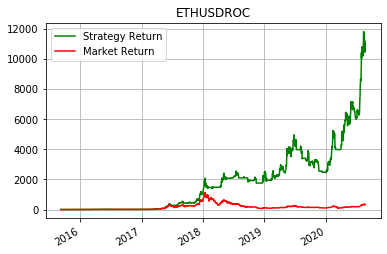

Strategy Return: 10954.15
Market Return: 329.95
Sortino Ratio: 4.27
Bars in Trade: 11
Buy Pct: 0.63
Accuracy: 0.54
Win Ratio: 0.54
Avg Win: 0.31
Avg Loss: 0.03
Risk to Reward: 10.58
Expectancy: 5.10
Sharpe Ratio: 2.39
Average Daily Return: 0.014
SL: 0.00 TP: 0.00


10954.147225831322

In [48]:
# Best for ETH
# Tested in Ensemble: SR is not improved
p.charts = True
p.stats = True
p.reload = True
run_model('ETH', period=17, threshold=-5, delay=2)

In [1]:
# Tested Combo with ROC model and various thresholds -> did not beat the current Combo model

In [1]:
td = 1
